In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1515442187683927380, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18283777205103728145
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import sys
import time
import math
import os
import pandas as pd
import numpy as np

import keras
from keras import layers, metrics, models, optimizers
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, concatenate, Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0


In [5]:
batch_size = 4
img_rows, img_cols = 512, 512
input_shape = (img_rows, img_cols, 3)
epochs = 150

In [6]:
train_dir = 'data_augmented/cvc300_train/'
validation_dir = 'data_augmented/cvc300_validation/'
test_dir = 'data_augmented/cvc300_test/'

image_folder = 'images'
masks_folder = 'masks'

In [7]:
"""
https://github.com/ykamikawa/PSPNet/blob/master/PSPNet.py
(512, 512, 3)
"""
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Reshape, Permute, Dense, Activation
from keras.layers import AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Lambda, Conv2DTranspose
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import multiply, add, concatenate
from keras.engine.topology import Layer
from keras.engine import InputSpec


def PSPNet50(img_size, n_labels=1, output_stride=16, num_blocks=4,
             levels=[6,3,2,1], use_se=True, output_mode="sigmoid",
             upsample_type='deconv'):
    input_shape = (img_size, img_size, 3)

    img_input = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, strides=(1, 1), use_se=use_se)
    x = identity_block(x, 3, [64, 64, 256], stage=2, use_se=use_se)
    x = identity_block(x, 3, [64, 64, 256], stage=2, use_se=use_se)

    x = conv_block(x, 3, [128, 128, 512], stage=3, use_se=use_se)
    x = identity_block(x, 3, [128, 128, 512], stage=3, use_se=use_se)
    x = identity_block(x, 3, [128, 128, 512], stage=3, use_se=use_se)
    x = identity_block(x, 3, [128, 128, 512], stage=3, use_se=use_se)

    if output_stride == 8:
        rate_scale = 2
    elif output_stride == 16:
        rate_scale = 1

    x = conv_block(x, 3, [256, 256, 1024], stage=4, dilation_rate=1*rate_scale,
                   multigrid=[1,1,1], use_se=use_se)
    x = identity_block(x, 3, [256, 256, 1024], stage=4,
                       dilation_rate=1*rate_scale, multigrid=[1, 1, 1],
                       use_se=use_se)
    x = identity_block(x, 3, [256, 256, 1024], stage=4,
                       dilation_rate=1*rate_scale, multigrid=[1, 1, 1],
                       use_se=use_se)
    x = identity_block(x, 3, [256, 256, 1024], stage=4,
                       dilation_rate=1*rate_scale, multigrid=[1, 1, 1],
                       use_se=use_se)
    x = identity_block(x, 3, [256, 256, 1024], stage=4,
                       dilation_rate=1*rate_scale, multigrid=[1, 1, 1],
                       use_se=use_se)
    x = identity_block(x, 3, [256, 256, 1024], stage=4,
                       dilation_rate=1*rate_scale, multigrid=[1, 1, 1],
                       use_se=use_se)

    init_rate = 2
    for block in range(4, num_blocks+1):
        x = conv_block(x, 3, [512, 512, 2048], stage=5,
                       dilation_rate=init_rate*rate_scale,
                       multigrid=[1, 1, 1], use_se=use_se)
        x = identity_block(x, 3, [512, 512, 2048], stage=5,
                           dilation_rate=init_rate*rate_scale,
                           multigrid=[1, 1, 1], use_se=use_se)
        x = identity_block(x, 3, [512, 512, 2048], stage=5,
                           dilation_rate=init_rate*rate_scale,
                           multigrid=[1, 1, 1], use_se=use_se)
        init_rate *= 2

    x = pyramid_pooling_module(x, 512, input_shape, output_stride, levels)

    if upsample_type == 'duc':
        x = duc(x, factor=output_stride,
                output_shape=(input_shape[0], input_shape[1], n_labels))
        out = Conv2D(n_labels, (1, 1), padding='same',
                     kernel_initializer="he_normal")(x)

    elif upsample_type == 'bilinear':
        x = Conv2D(n_labels, (1, 1), padding='same',
                   kernel_initializer="he_normal")(x)
        out = BilinearUpSampling2D((n_labels, input_shape[0], input_shape[1]),
                                   factor=output_stride)(x)

    elif upsample_type == 'deconv':
        out = Conv2DTranspose(n_labels, (output_stride*2, output_stride*2),
                              strides=(output_stride, output_stride),
                              padding='same',
                              kernel_initializer='he_normal',
                              use_bias=False)(x)
    out = Activation(output_mode)(out)

    model = Model(inputs=img_input, outputs=out)

    return model


def conv_block(input_tensor, kernel_size, filters, stage, strides=(2, 2),
               dilation_rate=1, multigrid=[1,2,1], use_se=True):
    filters1, filters2, filters3 = filters

    if dilation_rate > 1:
        strides = (1, 1)
    else:
        multigrid = [1, 1, 1]

    x = Conv2D(filters1, (1, 1), strides=strides,
               dilation_rate=dilation_rate*multigrid[0])(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               dilation_rate=dilation_rate*multigrid[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
               dilation_rate=dilation_rate*multigrid[2])(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides)(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    if use_se and stage < 5:
        se = _squeeze_excite_block(x, filters3, k=1)
        x = multiply([x, se])
    x = add([x, shortcut])
    x = Activation('relu')(x)

    return x


def _squeeze_excite_block(init, filters, k=1):
    se_shape = (1, 1, filters * k)

    se = GlobalAveragePooling2D()(init)
    se = Dense((filters * k) // 16, activation='relu',
               kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters * k, activation='sigmoid',
               kernel_initializer='he_normal', use_bias=False)(se)

    return se


def identity_block(input_tensor, kernel_size, filters, stage, dilation_rate=1,
                   multigrid=[1, 2, 1], use_se=True):
    filters1, filters2, filters3 = filters

    if dilation_rate < 2:
        multigrid = [1, 1, 1]

    x = Conv2D(filters1, (1, 1),
               dilation_rate=dilation_rate*multigrid[0])(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               dilation_rate=dilation_rate*multigrid[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
               dilation_rate=dilation_rate*multigrid[2])(x)
    x = BatchNormalization()(x)

    # stage 5 after
    if use_se and stage < 5:
        se = _squeeze_excite_block(x, filters3, k=1)
        x = multiply([x, se])
    x = add([x, input_tensor])
    x = Activation('relu')(x)

    return x


def pyramid_pooling_module(x, num_filters, input_shape, output_stride, levels):
    pyramid_pooling_blocks = [x]
    for level in levels:
        pyramid_pooling_blocks.append(interp_block(x, num_filters, input_shape,
                                                   output_stride, level))

    y = concatenate(pyramid_pooling_blocks)
    y = Conv2D(num_filters, (3, 3), padding='same',
               kernel_initializer="he_normal")(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    return y


def interp_block(x, num_filters, input_shape, output_stride, level):
    feature_map_shape = (input_shape[0]/output_stride,
                         input_shape[1]/output_stride)

    if output_stride == 16:
        scale = 5
    elif output_stride == 8:
        scale = 10

    kernel = (level*scale, level*scale)
    strides = (level*scale, level*scale)
    global_feat = AveragePooling2D(kernel, strides=strides)(x)
    global_feat = Conv2D(num_filters, (1, 1), padding='same',
                         kernel_initializer="he_normal")(global_feat)
    global_feat = BatchNormalization()(global_feat)
    global_feat = Lambda(Interp, arguments={'shape': feature_map_shape})(global_feat)

    return global_feat


def duc(x, factor=8, output_shape=(512,512,1)):
    H,W,c,r = output_shape[0],output_shape[1],output_shape[2],factor
    h = H/r
    w = W/r
    x = Conv2D(c*r*r,
            (3, 3),
            padding='same',
            name='conv_duc_%s'%factor)(x)
    x = BatchNormalization(name='bn_duc_%s'%factor)(x)
    x = Activation('relu')(x)
    x = Permute((3,1,2))(x)
    x = Reshape((c,r,r,h,w))(x)
    x = Permute((1,4,2,5,3))(x)
    x = Reshape((c,H,W))(x)
    x = Permute((2,3,1))(x)

    return x


class BilinearUpSampling2D(Layer):
    def __init__(self, target_shape=None, factor=None, data_format=None,
                 **kwargs):
        if data_format is None:
            data_format = K.image_data_format()
        assert data_format in {
            'channels_last', 'channels_first'}

        self.data_format = data_format
        self.input_spec = [InputSpec(ndim=4)]
        self.target_shape = target_shape
        self.factor = factor
        if self.data_format == 'channels_first':
            self.target_size = (target_shape[2], target_shape[3])
        elif self.data_format == 'channels_last':
            self.target_size = (target_shape[1], target_shape[2])
        super(BilinearUpSampling2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            return (input_shape[0], self.target_size[0],
                    self.target_size[1], input_shape[3])
        else:
            return (input_shape[0], input_shape[1],
                    self.target_size[0], self.target_size[1])

    def call(self, inputs):
        return K.resize_images(inputs, self.factor, self.factor, self.data_format)

    def get_config(self):
        config = {'target_shape': self.target_shape,
                  'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def Interp(x, shape):
    from keras.backend import tf as ktf
    new_height, new_width = shape
    resized = ktf.image.resize_images(x, [int(new_height), int(new_width)], align_corners=True)
    return resized

In [8]:
seed = 1142
data_gen_args = dict(rescale=1. / 255, featurewise_center=True, featurewise_std_normalization=True)
image_datagen = ImageDataGenerator(**data_gen_args)
masks_datagen = ImageDataGenerator(**data_gen_args)

test_datagen = ImageDataGenerator(rescale=1./255)

image_generator = image_datagen.flow_from_directory(
    train_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

mask_generator = masks_datagen.flow_from_directory(
    train_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

validation_image_generator = image_datagen.flow_from_directory(
    validation_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

validation_mask_generator = masks_datagen.flow_from_directory(
    validation_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

test_image_generator = test_datagen.flow_from_directory(
    test_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

test_mask_generator = test_datagen.flow_from_directory(
    test_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

Found 26112 images belonging to 1 classes.
Found 26112 images belonging to 1 classes.
Found 8704 images belonging to 1 classes.
Found 8704 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
Found 28 images belonging to 1 classes.


In [9]:
train_generator = zip(image_generator, mask_generator)
validation_generator = zip(validation_image_generator, validation_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)

In [10]:
nb_train_samples = len(image_generator.filenames)
nb_validation_samples = len(validation_image_generator.filenames)
nb_test_samples = len(test_image_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

nb_train_samples: 26112
nb_validation_samples: 8704
nb_test_samples: 28

predict_size_train: 6528
predict_size_validation: 2176
predict_size_test: 7


In [11]:
smooth = 1.
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def Specificity(y_true, y_pred):
    true_negatives = K.abs(y_pred)- K.abs(y_true)
    return ((true_negatives+smooth)/(y_pred+ smooth))

def Sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return ((y_pred+smooth)/ (y_true+smooth))

def Jaccard_index(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [12]:
model = PSPNet50(img_size = 512)
model.summary()
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer= adam_opt, loss=dice_coef_loss, 
              metrics=[dice_coef, 'acc','mse', Jaccard_index, Specificity, Sensitivity, precision, recall, f1score])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [13]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=nb_train_samples//batch_size,
                    epochs=epochs,
                    validation_data = validation_generator,
                    validation_steps = nb_validation_samples//batch_size)

Epoch 1/150
6528/6528 [==============================] - 2465s 378ms/step - loss: -0.1536 - dice_coef: 0.1536 - acc: 0.6705 - mean_squared_error: 0.1830 - Jaccard_index: 0.0854 - Specificity: 0.9636 - Sensitivity: 1.1745 - precision: 0.1104 - recall: 0.4159 - f1score: nan - val_loss: -0.1864 - val_dice_coef: 0.1864 - val_acc: 0.7188 - val_mean_squared_error: 0.1460 - val_Jaccard_index: 0.1079 - val_Specificity: 0.9530 - val_Sensitivity: 1.1009 - val_precision: 0.1518 - val_recall: 0.3371 - val_f1score: nan
Epoch 2/150
6528/6528 [==============================] - 2451s 376ms/step - loss: -0.6688 - dice_coef: 0.6688 - acc: 0.8248 - mean_squared_error: 0.0230 - Jaccard_index: 0.5243 - Specificity: 0.9703 - Sensitivity: 1.0102 - precision: 0.7423 - recall: 0.7154 - f1score: nan - val_loss: -0.6782 - val_dice_coef: 0.6782 - val_acc: 0.8263 - val_mean_squared_error: 0.0210 - val_Jaccard_index: 0.5318 - val_Specificity: 0.9608 - val_Sensitivity: 0.9936 - val_precision: 0.8985 - val_recall: 0.

Epoch 17/150
6528/6528 [==============================] - 2441s 374ms/step - loss: -0.9097 - dice_coef: 0.9097 - acc: 0.8400 - mean_squared_error: 0.0026 - Jaccard_index: 0.8377 - Specificity: 0.9758 - Sensitivity: 1.0027 - precision: 0.9867 - recall: 0.9829 - f1score: 0.9847 - val_loss: -0.7808 - val_dice_coef: 0.7808 - val_acc: 0.8284 - val_mean_squared_error: 0.0159 - val_Jaccard_index: 0.6604 - val_Specificity: 0.9645 - val_Sensitivity: 0.9983 - val_precision: 0.9274 - val_recall: 0.7985 - val_f1score: 0.8408
Epoch 18/150
6528/6528 [==============================] - 2439s 374ms/step - loss: -0.9101 - dice_coef: 0.9101 - acc: 0.8400 - mean_squared_error: 0.0026 - Jaccard_index: 0.8383 - Specificity: 0.9758 - Sensitivity: 1.0027 - precision: 0.9872 - recall: 0.9836 - f1score: 0.9854 - val_loss: -0.7796 - val_dice_coef: 0.7796 - val_acc: 0.8286 - val_mean_squared_error: 0.0158 - val_Jaccard_index: 0.6586 - val_Specificity: 0.9644 - val_Sensitivity: 0.9979 - val_precision: 0.9316 - val

Epoch 33/150
6528/6528 [==============================] - 2457s 376ms/step - loss: -0.9147 - dice_coef: 0.9147 - acc: 0.8402 - mean_squared_error: 0.0022 - Jaccard_index: 0.8461 - Specificity: 0.9759 - Sensitivity: 1.0027 - precision: 0.9922 - recall: 0.9892 - f1score: 0.9907 - val_loss: -0.7803 - val_dice_coef: 0.7803 - val_acc: 0.8287 - val_mean_squared_error: 0.0158 - val_Jaccard_index: 0.6595 - val_Specificity: 0.9643 - val_Sensitivity: 0.9977 - val_precision: 0.9362 - val_recall: 0.7908 - val_f1score: 0.8403
Epoch 34/150
6528/6528 [==============================] - 2461s 377ms/step - loss: -0.9151 - dice_coef: 0.9151 - acc: 0.8402 - mean_squared_error: 0.0022 - Jaccard_index: 0.8468 - Specificity: 0.9759 - Sensitivity: 1.0026 - precision: 0.9925 - recall: 0.9895 - f1score: 0.9909 - val_loss: -0.7858 - val_dice_coef: 0.7858 - val_acc: 0.8287 - val_mean_squared_error: 0.0154 - val_Jaccard_index: 0.6660 - val_Specificity: 0.9647 - val_Sensitivity: 0.9985 - val_precision: 0.9298 - val

Epoch 49/150
6528/6528 [==============================] - 2449s 375ms/step - loss: -0.9172 - dice_coef: 0.9172 - acc: 0.8403 - mean_squared_error: 0.0021 - Jaccard_index: 0.8506 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9951 - recall: 0.9926 - f1score: 0.9938 - val_loss: -0.7723 - val_dice_coef: 0.7723 - val_acc: 0.8286 - val_mean_squared_error: 0.0163 - val_Jaccard_index: 0.6514 - val_Specificity: 0.9639 - val_Sensitivity: 0.9969 - val_precision: 0.9401 - val_recall: 0.7781 - val_f1score: 0.8314
Epoch 50/150
6528/6528 [==============================] - 2448s 375ms/step - loss: -0.9175 - dice_coef: 0.9175 - acc: 0.8403 - mean_squared_error: 0.0020 - Jaccard_index: 0.8509 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9953 - recall: 0.9927 - f1score: 0.9940 - val_loss: -0.7762 - val_dice_coef: 0.7762 - val_acc: 0.8286 - val_mean_squared_error: 0.0160 - val_Jaccard_index: 0.6560 - val_Specificity: 0.9641 - val_Sensitivity: 0.9974 - val_precision: 0.9368 - val

Epoch 65/150
6528/6528 [==============================] - 2464s 377ms/step - loss: -0.9191 - dice_coef: 0.9191 - acc: 0.8404 - mean_squared_error: 0.0020 - Jaccard_index: 0.8538 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9969 - recall: 0.9947 - f1score: 0.9958 - val_loss: -0.7805 - val_dice_coef: 0.7805 - val_acc: 0.8286 - val_mean_squared_error: 0.0159 - val_Jaccard_index: 0.6609 - val_Specificity: 0.9643 - val_Sensitivity: 0.9978 - val_precision: 0.9338 - val_recall: 0.7950 - val_f1score: 0.8403
Epoch 66/150
6528/6528 [==============================] - 2464s 377ms/step - loss: -0.9189 - dice_coef: 0.9189 - acc: 0.8404 - mean_squared_error: 0.0019 - Jaccard_index: 0.8535 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9969 - recall: 0.9948 - f1score: 0.9959 - val_loss: -0.7825 - val_dice_coef: 0.7825 - val_acc: 0.8286 - val_mean_squared_error: 0.0158 - val_Jaccard_index: 0.6639 - val_Specificity: 0.9645 - val_Sensitivity: 0.9981 - val_precision: 0.9320 - val

Epoch 81/150
6528/6528 [==============================] - 2452s 376ms/step - loss: -0.9200 - dice_coef: 0.9200 - acc: 0.8404 - mean_squared_error: 0.0019 - Jaccard_index: 0.8553 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9976 - recall: 0.9957 - f1score: 0.9967 - val_loss: -0.7794 - val_dice_coef: 0.7794 - val_acc: 0.8287 - val_mean_squared_error: 0.0159 - val_Jaccard_index: 0.6605 - val_Specificity: 0.9642 - val_Sensitivity: 0.9975 - val_precision: 0.9359 - val_recall: 0.7910 - val_f1score: 0.8385
Epoch 82/150
6528/6528 [==============================] - 2452s 376ms/step - loss: -0.9197 - dice_coef: 0.9197 - acc: 0.8404 - mean_squared_error: 0.0019 - Jaccard_index: 0.8548 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9977 - recall: 0.9958 - f1score: 0.9967 - val_loss: -0.7789 - val_dice_coef: 0.7789 - val_acc: 0.8287 - val_mean_squared_error: 0.0159 - val_Jaccard_index: 0.6582 - val_Specificity: 0.9641 - val_Sensitivity: 0.9972 - val_precision: 0.9398 - val

Epoch 97/150
6528/6528 [==============================] - 2457s 376ms/step - loss: -0.9198 - dice_coef: 0.9198 - acc: 0.8404 - mean_squared_error: 0.0019 - Jaccard_index: 0.8550 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9980 - recall: 0.9961 - f1score: 0.9970 - val_loss: -0.7761 - val_dice_coef: 0.7761 - val_acc: 0.8287 - val_mean_squared_error: 0.0161 - val_Jaccard_index: 0.6560 - val_Specificity: 0.9640 - val_Sensitivity: 0.9972 - val_precision: 0.9388 - val_recall: 0.7846 - val_f1score: 0.8355
Epoch 98/150
6528/6528 [==============================] - 2465s 378ms/step - loss: -0.9201 - dice_coef: 0.9201 - acc: 0.8404 - mean_squared_error: 0.0019 - Jaccard_index: 0.8554 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9980 - recall: 0.9961 - f1score: 0.9970 - val_loss: -0.7727 - val_dice_coef: 0.7727 - val_acc: 0.8286 - val_mean_squared_error: 0.0164 - val_Jaccard_index: 0.6522 - val_Specificity: 0.9639 - val_Sensitivity: 0.9970 - val_precision: 0.9387 - val

Epoch 113/150
6528/6528 [==============================] - 2459s 377ms/step - loss: -0.9204 - dice_coef: 0.9204 - acc: 0.8404 - mean_squared_error: 0.0019 - Jaccard_index: 0.8560 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9982 - recall: 0.9964 - f1score: 0.9973 - val_loss: -0.7632 - val_dice_coef: 0.7632 - val_acc: 0.8284 - val_mean_squared_error: 0.0170 - val_Jaccard_index: 0.6406 - val_Specificity: 0.9634 - val_Sensitivity: 0.9962 - val_precision: 0.9416 - val_recall: 0.7620 - val_f1score: 0.8215
Epoch 114/150
6528/6528 [==============================] - 2454s 376ms/step - loss: -0.9203 - dice_coef: 0.9203 - acc: 0.8404 - mean_squared_error: 0.0019 - Jaccard_index: 0.8558 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9981 - recall: 0.9964 - f1score: 0.9973 - val_loss: -0.7790 - val_dice_coef: 0.7790 - val_acc: 0.8288 - val_mean_squared_error: 0.0158 - val_Jaccard_index: 0.6597 - val_Specificity: 0.9642 - val_Sensitivity: 0.9973 - val_precision: 0.9397 - v

Epoch 129/150
6528/6528 [==============================] - 2457s 376ms/step - loss: -0.9204 - dice_coef: 0.9204 - acc: 0.8404 - mean_squared_error: 0.0019 - Jaccard_index: 0.8560 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9983 - recall: 0.9966 - f1score: 0.9974 - val_loss: -0.7786 - val_dice_coef: 0.7786 - val_acc: 0.8287 - val_mean_squared_error: 0.0159 - val_Jaccard_index: 0.6584 - val_Specificity: 0.9642 - val_Sensitivity: 0.9976 - val_precision: 0.9356 - val_recall: 0.7884 - val_f1score: 0.8377
Epoch 130/150
6528/6528 [==============================] - 2457s 376ms/step - loss: -0.9200 - dice_coef: 0.9200 - acc: 0.8404 - mean_squared_error: 0.0019 - Jaccard_index: 0.8553 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9980 - recall: 0.9962 - f1score: 0.9971 - val_loss: -0.7694 - val_dice_coef: 0.7694 - val_acc: 0.8286 - val_mean_squared_error: 0.0164 - val_Jaccard_index: 0.6511 - val_Specificity: 0.9639 - val_Sensitivity: 0.9971 - val_precision: 0.9372 - v

Epoch 145/150
6528/6528 [==============================] - 2459s 377ms/step - loss: -0.9204 - dice_coef: 0.9204 - acc: 0.8404 - mean_squared_error: 0.0019 - Jaccard_index: 0.8561 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9984 - recall: 0.9970 - f1score: 0.9977 - val_loss: -0.7761 - val_dice_coef: 0.7761 - val_acc: 0.8287 - val_mean_squared_error: 0.0161 - val_Jaccard_index: 0.6555 - val_Specificity: 0.9640 - val_Sensitivity: 0.9971 - val_precision: 0.9406 - val_recall: 0.7826 - val_f1score: 0.8356
Epoch 146/150
6528/6528 [==============================] - 2454s 376ms/step - loss: -0.9207 - dice_coef: 0.9207 - acc: 0.8404 - mean_squared_error: 0.0019 - Jaccard_index: 0.8565 - Specificity: 0.9760 - Sensitivity: 1.0026 - precision: 0.9984 - recall: 0.9969 - f1score: 0.9976 - val_loss: -0.7663 - val_dice_coef: 0.7663 - val_acc: 0.8286 - val_mean_squared_error: 0.0168 - val_Jaccard_index: 0.6447 - val_Specificity: 0.9635 - val_Sensitivity: 0.9963 - val_precision: 0.9430 - v

In [14]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  -0.7667666560411454
Validation Accuracy:  0.7667666560411454


In [15]:
prediction = model.predict_generator(test_generator, verbose=1, steps=nb_test_samples)

28/28 [==============================] - 4s 140ms/step


In [16]:
prediction.shape

(112, 512, 512, 1)

In [17]:
test_results = model.evaluate_generator(test_generator, steps=50)

print(model.metrics_names)
print(test_results)

['loss', 'dice_coef', 'acc', 'mean_squared_error', 'Jaccard_index', 'Specificity', 'Sensitivity', 'precision', 'recall', 'f1score']
[-0.8470228499174118, 0.8470228499174118, 0.9867490959167481, 0.01302079098764807, 0.7624162492156029, 0.9700357627868652, 0.9969150114059449, 0.9335356044769287, 0.8065314799547195, 0.8471782588958741]


In [18]:
coef = np.array(history.history['Jaccard_index'])
val_coef = np.array(history.history['val_Jaccard_index'])
print("Training co-effiency    : {};\nValidation co-effiency : {}".format(coef[coef==max(coef)][0], val_coef[np.argmax(coef)]))

Training co-effiency    : 0.8565467512052433;
Validation co-effiency : 0.6450701266559704


In [20]:
import skimage.io as io

def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

os.mkdir('10.PSPNet50_results_dir')

In [21]:
saveResult('10.PSPNet50_results_dir',prediction)

In [23]:
def normalizeData(img,mask):
    mean = np.mean(img)
    std = np.std(img)
    img -= mean
    img /= std
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

test_data_dir= "data_augmented/cvc300_test/images/"
test_data_mask_dir = "data_augmented/cvc300_test/masks/"
test_data_pred_dir = "10.PSPNet50_results_dir"
img_rows, img_cols = 256, 256

In [24]:
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

file_names = next(os.walk(test_data_dir))[2]
scores = []
for file in file_names:
    grey_img = load_img(os.path.join(test_data_dir,file), target_size=(img_rows, img_cols), grayscale=False)
    mask_img = load_img(os.path.join(test_data_mask_dir,file), target_size=(img_rows, img_cols), grayscale=True)
    img = img_to_array(grey_img)
    img_mask = img_to_array(mask_img)
    
    img, img_mask = normalizeData(img, img_mask)
    img = np.reshape(img,(1,)+img.shape)
    
    pred = model.predict([img])
    sess = tf.Session()
    score = sess.run(Jaccard_index(img_mask, pred))
    print("{} -- jaccard index: {}".format(file,score))
    scores.append([file,score])

    result_img = array_to_img(pred[0] * 255 )
    result_img.save(os.path.join(test_data_pred_dir, file.split('.')[0] + '_predict.jpg'))

with open("unet_test_result.csv", 'w') as f:
    f.write("filename, jaccard_index\n")
    for i in range(len(scores)):
        #print(scores[i])
        f.write("{},{}\n".format(scores[i][0], scores[i][1]))

ValueError: Error when checking input: expected input_1 to have shape (512, 512, 3) but got array with shape (256, 256, 3)

Populating the interactive namespace from numpy and matplotlib


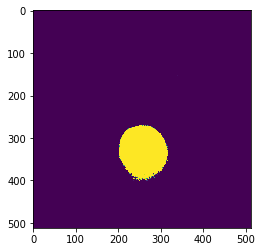

In [25]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('10.PSPNet50_results_dir/102_predict.png')
imgplot = plt.imshow(img)
plt.show()

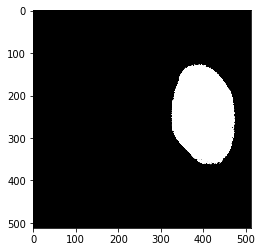

In [26]:
plt.imshow(np.squeeze(prediction[1]), cmap = "gray")

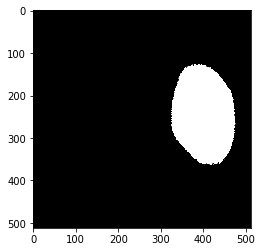

In [27]:
plt.imshow(np.squeeze(prediction[1]), cmap = "gray", vmin = 0.0, vmax= 0.09)

[[5.0519516e-06 8.0069021e-06 9.0966259e-06 ... 4.7527188e-05
  2.0820278e-05 2.8622560e-05]
 [9.1147535e-07 1.0588739e-06 1.2355899e-06 ... 2.4217632e-05
  2.3047971e-05 2.8903612e-05]
 [3.1463267e-05 2.2419010e-06 6.7238539e-06 ... 4.0554856e-05
  9.2272503e-06 1.2011006e-05]
 ...
 [1.7847022e-05 1.7158633e-05 2.2093938e-05 ... 7.9565376e-07
  2.8412649e-06 9.8073606e-06]
 [5.2593441e-06 1.1322943e-05 2.4530634e-06 ... 6.1780759e-07
  3.2421085e-05 2.5181284e-06]
 [9.9023391e-06 2.5835839e-06 6.6012517e-06 ... 2.9803075e-06
  7.0778777e-05 1.7472203e-06]]


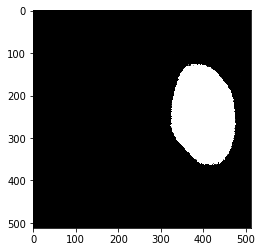

In [28]:
results_ =  np.squeeze(np.multiply(prediction[1], 255))
print(results_)

plt.imshow(results_, cmap = "gray", vmin = 0.0, vmax= 0.7)
plt.show()

Populating the interactive namespace from numpy and matplotlib


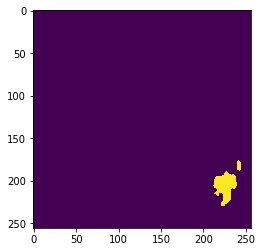

In [29]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('05.U-Net2_results_dir/35_predict.png')
imgplot = plt.imshow(img)
plt.show()

dict_keys(['Specificity', 'loss', 'val_loss', 'val_f1score', 'val_acc', 'val_recall', 'f1score', 'val_Specificity', 'val_dice_coef', 'precision', 'Sensitivity', 'val_precision', 'acc', 'dice_coef', 'recall', 'Jaccard_index', 'mean_squared_error', 'val_Jaccard_index', 'val_mean_squared_error', 'val_Sensitivity'])


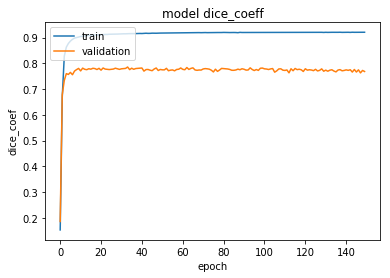

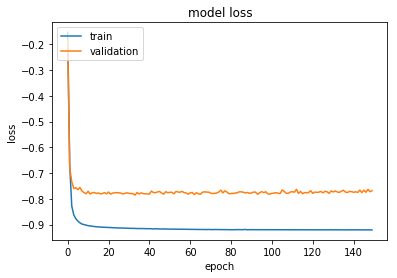

In [30]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coeff')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()